# Exploratory Data Analysis LinkedIn Job Posting

  ## Objectives
Exploratory Data Analysis LinkedIn Job Posting
- Handle the LinkedIn job postings DataFrame
- Analyze the Top Words in Job Titles
- Extract Jobs in the Data Field
- Extract the Top Skill Required for Data Jobs
- Identify the Best Time to Post a Job
- Determine the Top Skills Necessary for Data Jobs
- Distribution of Average Salary


### Import The Libraies

In [80]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Handle the LinkedIn job postings DataFrame

In [81]:
df_job = pd.read_csv('linkedin_job_postings.csv')

In [82]:
df_job.head(3)

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite


In [83]:
df_job.shape

(1348454, 14)

In [84]:
df_job.columns

Index(['job_link', 'last_processed_time', 'got_summary', 'got_ner',
       'is_being_worked', 'job_title', 'company', 'job_location', 'first_seen',
       'search_city', 'search_country', 'search_position', 'job_level',
       'job_type'],
      dtype='object')

In [85]:
df_job.drop(columns=['got_summary', 'got_ner', 'is_being_worked'], inplace=True)

In [86]:
df_job.columns

Index(['job_link', 'last_processed_time', 'job_title', 'company',
       'job_location', 'first_seen', 'search_city', 'search_country',
       'search_position', 'job_level', 'job_type'],
      dtype='object')

In [87]:
df_job.isnull().sum()

job_link                0
last_processed_time     0
job_title               0
company                11
job_location           19
first_seen              0
search_city             0
search_country          0
search_position         0
job_level               0
job_type                0
dtype: int64

## Finding the Top Words in Job Titles

In [88]:
Words = []
prepositions = set(stopwords.words('english'))
for value in df_job['job_title'].values:
    va = re.sub(r'[^\w\s]', '', value)
    word = va.split()
    word = [w for w in word if w not in prepositions]
    Words.extend(word)

In [89]:
df_word = pd.DataFrame(Words)
df_word.columns = ['Word']

In [90]:
df_word.value_counts().head()

Word    
Manager     252821
Nurse       111096
Senior       97656
RN           86792
Engineer     81214
Name: count, dtype: int64

In [91]:
word = df_word['Word'].value_counts().head(50).index
count = df_word['Word'].value_counts().head(50).values
word_freq = dict(zip(word, count))

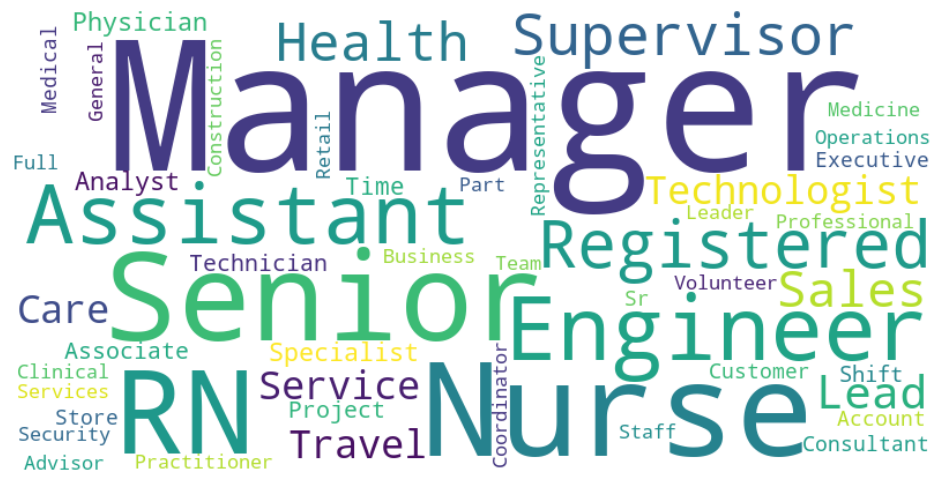

In [92]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Export Jobs in the Data Field

In [93]:
def job_data_export(job_title):
    if 'data' in str(job_title).lower() or 'analy' in str(job_title).lower():
        return job_title
    else:
        return None

In [94]:
df_job['data_job_title'] = df_job['job_title'].apply(job_data_export)
df_data_job = df_job.dropna(subset='data_job_title').drop(columns='job_title')

In [95]:
df_data_job.drop_duplicates(subset=['data_job_title', 'company',
       'job_location', 'search_country',
       'search_position', 'job_level', 'job_type'], inplace= True)

## Extract the Top Skill Required for Data Jobs

In [96]:
df_skill = pd.read_csv('job_skills.csv')

In [97]:
df_data_job = df_skill.merge(df_data_job, how='inner', on='job_link')
skills = []
for value in df_data_job['job_skills'].value_counts().index:
    skills.extend(item.strip().title() for item in value.split(','))
skills = pd.DataFrame(skills, columns=['skill'])

## Combine the job dataframe and job description dataframe


In [98]:
df_summary = pd.read_csv('job_summary.csv')

In [99]:
#df_data_analyst = df_summary.merge(df_data_job, how='inner', on='job_link')
#df_data_analyst.reset_index(drop= True, inplace=True)
#df_data_analyst.to_csv('data_analyst.csv', index=False)

In [100]:
df_data_analyst = pd.read_csv('data_analyst.csv')

## Extract Salary Information from Job Descriptions

Get APIs convert currency from GBP to USD

In [154]:
import requests
api_key = '3e80bf9aec65d0e858d15c85'
base_url = f'https://v6.exchangerate-api.com/v6/{api_key}/latest/'
response = requests.get(base_url + 'GBP')
data = response.json()


In [155]:
def salary_extract(summary):
    if 'salary' in summary.lower():
        if re.search(r'\$', summary):
            match = re.findall(r'\$([\d,]+)', summary)
            split = [(s.replace(',', '')) for s in match]
            salary = [int(num) for num in split if len(num) >= 5]
            return salary[:2]
        elif re.search(r'\£', summary):
            match = re.findall(r'\£([\d,]+)', summary)
            split = [(s.replace(',', '')) for s in match]
            salary = [int(num) * data['conversion_rates']['USD'] for num in split if len(num) >= 5]
            return salary[:2]

In [156]:
df_salary_data = df_data_analyst['job_summary'].apply(lambda x: pd.Series(salary_extract(x)))
df_salary_data.columns = ['min', 'max']
df_salary_data.dropna(subset=['min'],inplace=True)
df_salary_data['max'] = df_salary_data['max'].fillna(df_salary_data['min'])
df_salary_data['Average'] = (df_salary_data.iloc[:, 0] + df_salary_data.iloc[:, 1])/2

In [157]:
df_orders = df_summary.merge(df_data_analyst, how= 'outer',on= 'job_link')
df_orders = df_orders[df_orders['job_summary_y'].isna()]

In [158]:
df_salary_orders = df_orders['job_summary_x'].apply(lambda x: pd.Series(salary_extract(x)))
df_salary_orders.columns = ['min', 'max']
df_salary_orders.dropna(subset=['min'],inplace=True)
df_salary_orders['max'] = df_salary_orders['max'].fillna(df_salary_orders['min'])
df_salary_orders['Average'] = (df_salary_orders.iloc[:, 0] + df_salary_orders.iloc[:, 1])/2

In [159]:
df_salary_orders = df_salary_orders[(df_salary_orders['Average']>0) & (df_salary_orders['Average']<1000000)]

In [160]:
df_salary_data = df_salary_data[(df_salary_data['Average']>0) & (df_salary_data['Average']<1000000)]

In [108]:
#df_salary_data.to_csv('salary.csv')

In [162]:
#df_salary_orders.to_csv('salary_others.csv')

## Extract experience Information from Job Descriptions

In [169]:
def salary_extract(summary):
    pattern = r'(\d+\+?\s*years?)'
    summary = summary.lower()
    matches =  re.findall(r'\n(.*(?:experience.*years|years.*experience).*)\n', summary)
    for match in matches:
        if re.search(r'a year', match):
            experience = '1 year'
            return experience
        elif re.search(pattern, match) and int(re.search(r'(\d+)\+?\s*years?', match).group(1))<20:
            experience = re.search(pattern, match).group(1)
            return experience
        else:
            return None

In [170]:
df_experience = df_data_analyst['job_summary'].apply(lambda x: pd.Series(salary_extract(x)))
df_experience.columns = ['Experience']
df_experience.dropna(inplace=True)
df_experience['Year'] = df_experience['Experience'].str.extract(r'(\d+)').astype(int)

In [111]:
#df_experience.to_csv('experience.csv')

## Combine the salary dataframe and experience dataframe


In [171]:
def categorize_experience(year):
    if year >= 0 and year <= 3:
        return 'Beginner'
    elif year >= 4 and year <= 5:
        return 'Junior'
    elif year >= 6 and year <= 10:
        return 'Mid-level'
    else:
        return 'Senior'

In [172]:
df_Experience_Segment = df_experience.join(df_salary_data, how='inner')
df_Experience_Segment['Experience_Segment'] = df_Experience_Segment['Year'].apply(categorize_experience)
df_Experience_Segment = df_Experience_Segment[df_Experience_Segment['Average']<= np.percentile(df_Experience_Segment['Average'], 99)]

## Identify the Best Time to Post a Job

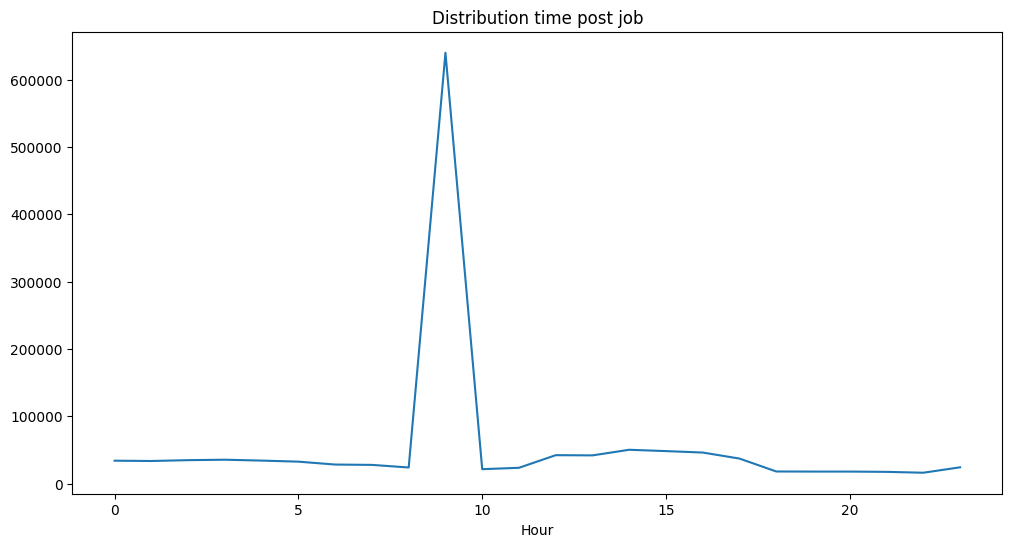

In [114]:
df_job.drop(index=1184304, inplace=True)
df_job['last_processed_time'] = pd.to_datetime(df_job['last_processed_time'])
plt.figure(figsize=(12, 6))
df_job['Hour'] = df_job['last_processed_time'].dt.hour
df_job['Hour'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour')
plt.title('Distribution time post job')
plt.show()

## Identifying the top skills necessary for data job

In [115]:
data = skills['skill'].value_counts().head(10).to_frame().reset_index()

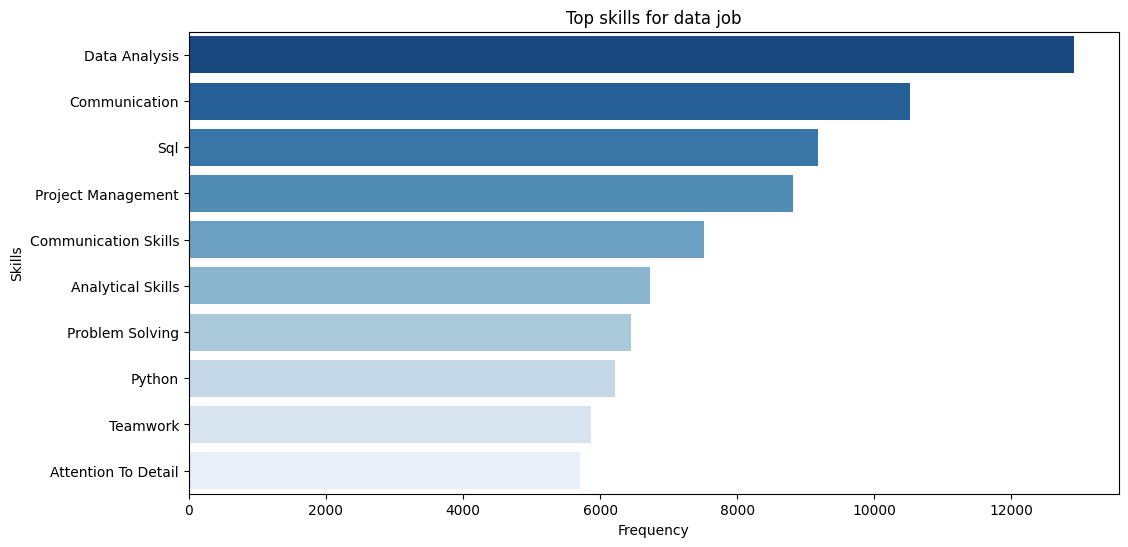

In [116]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Blues_r",n_colors=10)
sns.barplot(data,orient='h', x ='count', y = 'skill', hue='skill', palette=palette)
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top skills for data job')
plt.show()

## Distribution of Average Salary

In [173]:
import statistics
Q2_1 = statistics.median(df_Experience_Segment['Average'][df_Experience_Segment['Experience_Segment'] == 'Beginner'])
Q2_2 = statistics.median(df_Experience_Segment['Average'][df_Experience_Segment['Experience_Segment'] == 'Junior'])
Q2_3 = statistics.median(df_Experience_Segment['Average'][df_Experience_Segment['Experience_Segment'] == 'Mid-level'])
Q2_4 = statistics.median(df_Experience_Segment['Average'][df_Experience_Segment['Experience_Segment'] == 'Senior'])
median_value = np.median(df_Experience_Segment['Average'])

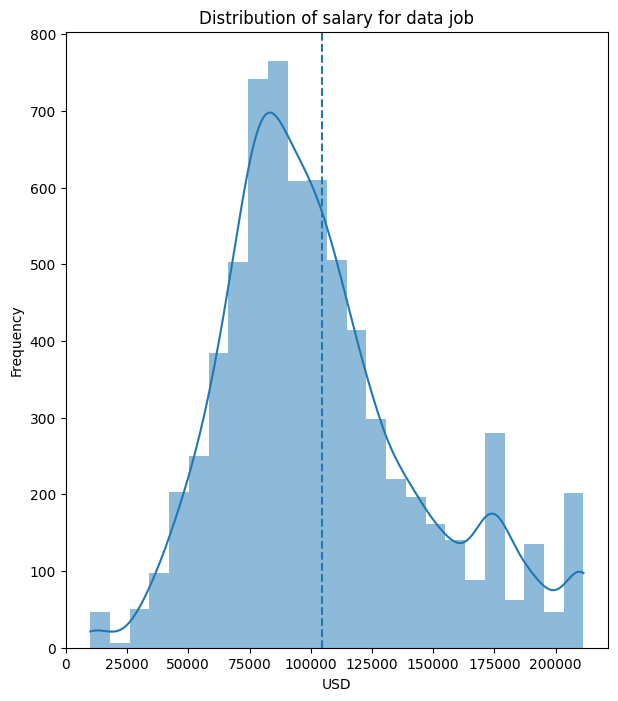

In [163]:
percentile_95 = np.percentile(df_salary_data['Average'], 95)
df_salary_data_95 = df_salary_data[df_salary_data['Average']<=percentile_95]
plt.figure(figsize=(7, 8))
sns.histplot(df_salary_data_95['Average'], kde=True, linewidth=0, bins=25)
plt.axvline(np.mean(df_salary_data_95['Average']), linestyle='--')
plt.xlabel('USD')
plt.ylabel('Frequency')
plt.title('Distribution of salary for data job')
plt.show()

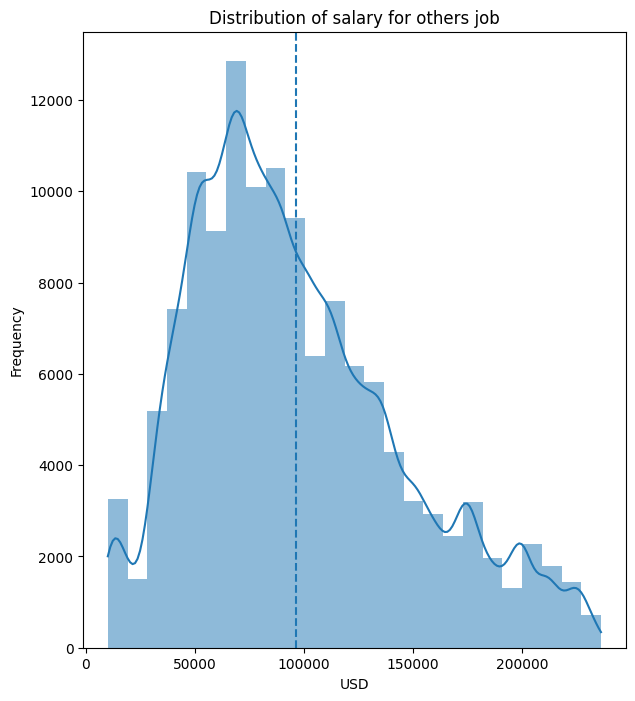

In [164]:
percentile_95 = np.percentile(df_salary_orders['Average'], 95)
df_salary_95 = df_salary_orders[df_salary_orders['Average']<=percentile_95]
plt.figure(figsize=(7, 8))
sns.histplot(df_salary_95['Average'], kde=True, linewidth=0, bins=25)
plt.axvline(np.mean(df_salary_95['Average']), linestyle='--')
plt.xlabel('USD')
plt.ylabel('Frequency')
plt.title('Distribution of salary for others job')
plt.show()

C:\Users\vanhu\AppData\Local\Temp\ipykernel_3384\2002085330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salary_data_95['Source'] = 'Data Job'
C:\Users\vanhu\AppData\Local\Temp\ipykernel_3384\2002085330.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salary_95['Source'] = 'Other Job'


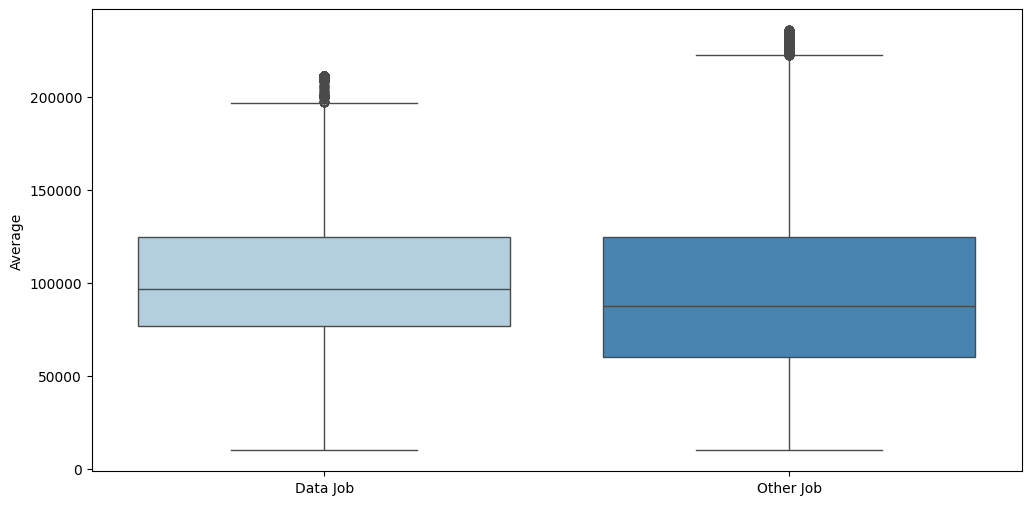

In [166]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Blues",n_colors=2)
df_salary_data_95['Source'] = 'Data Job'
df_salary_95['Source'] = 'Other Job'
df_combined = pd.concat([df_salary_data_95[['Average', 'Source']], df_salary_95[['Average', 'Source']]])
sns.boxplot(x='Source', y='Average', data=df_combined,hue='Source', palette=palette)
plt.xlabel('')
plt.show()

## Average Salary Distribution by Position

Distribution of the position

(-1.1197542642061988,
 1.1192208814866191,
 -1.1106737499801669,
 1.1211450686429836)

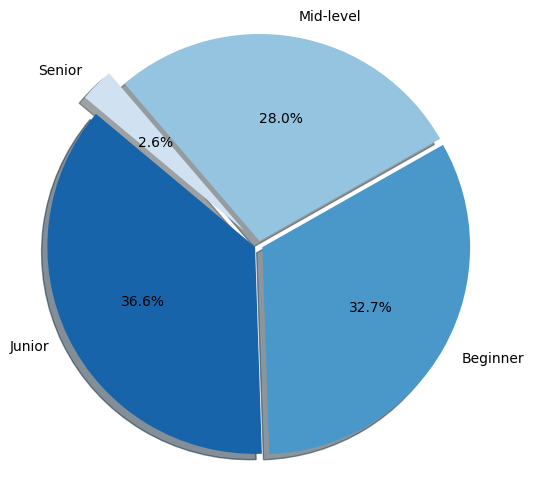

In [121]:
df_count = df_Experience_Segment['Experience_Segment'].value_counts().to_frame().reset_index()
plt.figure(figsize=(6, 6))
colors = sns.color_palette("Blues_r",n_colors=4)
explode = (0.02, 0.02, 0.02, 0.1) 
plt.pie(df_count['count'], explode=explode, labels=df_count['Experience_Segment'], colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

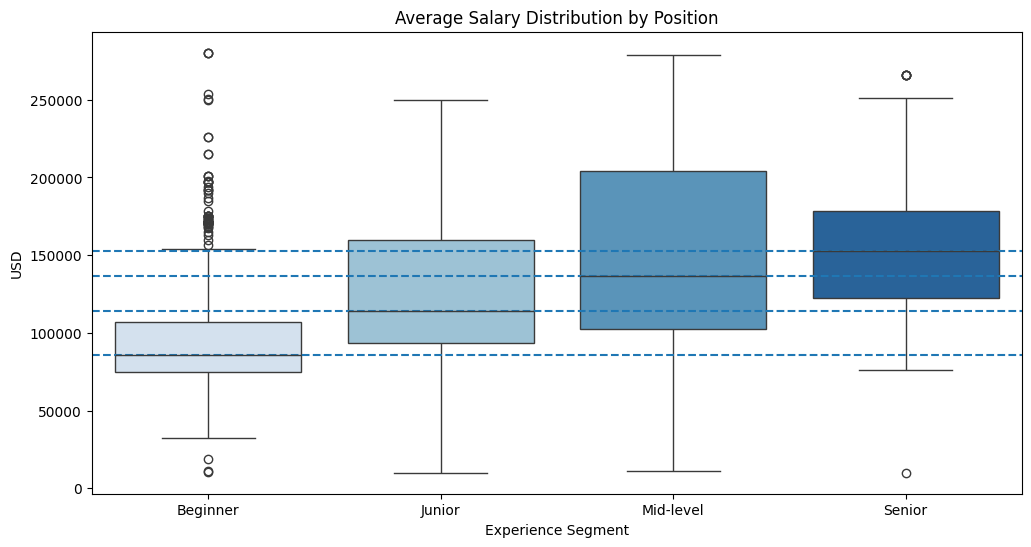

In [174]:
df_Experience_Segment = df_Experience_Segment.sort_values(by='Experience_Segment')
experience_order = ['Beginner', 'Junior', 'Mid-level', 'Senior'] 
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Blues",n_colors=4)
sns.boxplot(x='Experience_Segment', y='Average', data=df_Experience_Segment, hue='Experience_Segment', palette=palette)
plt.axhline(Q2_1, linestyle='--')
plt.axhline(Q2_2, linestyle='--')
plt.axhline(Q2_3, linestyle='--')
plt.axhline(Q2_4, linestyle='--')
plt.xlabel('Experience Segment')
plt.ylabel('USD')
plt.title('Average Salary Distribution by Position')
plt.show()

<code>©2024 Huu Hoai</code>